In [1]:
import pygbif as gbif
from pygbif import occurrences as occ
from pygbif import maps
from pygbif import species
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
import matplotlib.pyplot as plt

import geodatasets
import contextily as cx
import pyperclip


# let's map Trichostema - what a lovely genus of plants

In [47]:
#taxon key 2926651 is the key for the genus 'Trichostema' in GBIF
#here we are using the facet tool to provide counts of all species in the genus, and their species keys, in the US, in North Carolina
occ_facet = occ.search(taxonKey=2926651, country = 'US', stateProvince = 'North Carolina',  facet = ['scientificName', 'speciesKey'], limit = 1000)

#we can check our results with the below line - these queries return a staggering amount of metadata - 100's of fields. We are only interested in the species names and species keys, so we are using the facet tool to limit the amount of data returned
occ_facet['facets'][0]['counts']
species_dict = {}
i = 0
for each in occ_facet['facets'][0]['counts']:
    try: 
        species_dict[each['name']] = occ_facet['facets'][1]['counts'][i]['name']
        i += 1
   
    except IndexError:
        print(i)

#for this genus, there are 4 species in NC - the GBIF API also returns a fifth set of records, for members of the genus with no species designation. We are dropping them with the indexerror catch above, to save time, but you might want to keep them



4


In [48]:
#now we have a dictionary of species names and keys, we can use the species API to get distribution maps from the keys

species_dict

{'trichostema dichotomum l.': '2926665',
 'trichostema nesophilum k.s.mcclell. & weakley': '10891312',
 'trichostema setaceum houtt.': '2926662',
 'trichostema brachiatum l.': '2927171'}

In [51]:
master = gpd.GeoDataFrame()

for each in species_dict:
    #get the records for a given species
    resp = occ.search( hasCoordinate=True, hasGeospatialIssue=False, limit=300, country = 'US', stateProvince = 'North Carolina', speciesKey = species_dict[each])
    df = pd.DataFrame.from_dict(resp['results'])
    df['species'] = each
    df['decimalLatitude'] = pd.to_numeric(df['decimalLatitude'])
    df['decimalLongitude'] = pd.to_numeric(df['decimalLongitude'])
    df['geometry'] = gpd.points_from_xy(df['decimalLongitude'], df['decimalLatitude'])

    #convert records to geodataframe and add to the master
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    #add plot to master plot
    master = pd.concat([master, gdf], axis = 0, ignore_index = True, sort = True)



## Let's see what the map looks like - nesophyllum is relegated to barrier islands, dichotomum seems quite widespread and setaceum seems relegated to some very specific habitats - further digging show's it's a specialist for rocky outcroppings with sandy margins

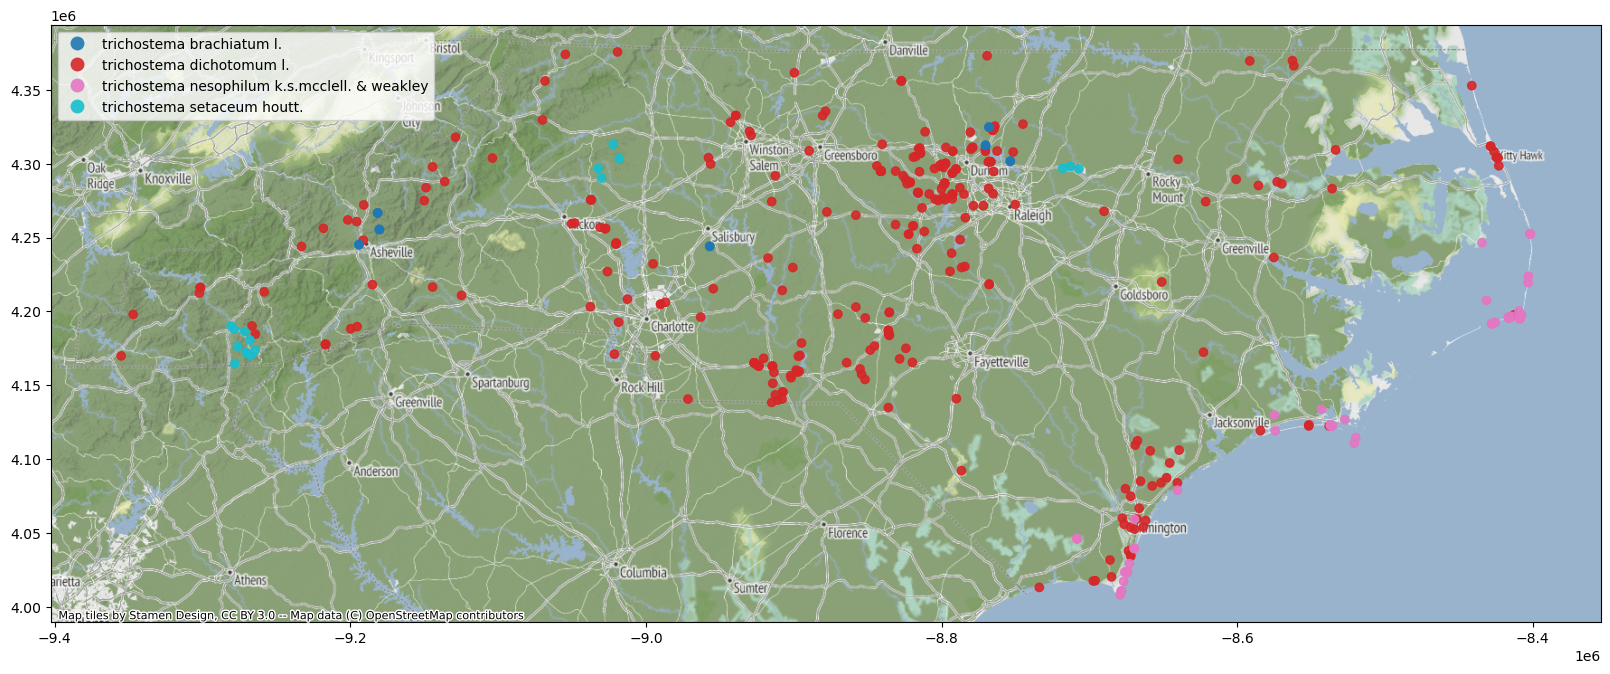

In [60]:
fig, ax = plt.subplots(figsize = (20,20))

master.set_crs(epsg=4326, inplace = True) #reproject to web mercator
#reproject to web mercator
master_wm = master.to_crs(epsg=3857)
ax = master_wm.plot(column = 'species', ax = ax, legend = True, alpha = 0.9)
cx.add_basemap(ax) #use contextily to add basemap from OSM
plt.show()
fig.savefig('NC_trichostema_map.png',bbox_inches='tight')

# let's say youre bored this weekend and want to go fossil hunting - how are you going to find the roadcuts to complete your collection?

In [33]:
#taxonkey 110 is for brachiopods
#filter to only fossil specimens (though these are saltwater creatures so I wouldn't expect living specimens anyways)
#here we filter to family names rather than species names
occ_facet = occ.search(taxonKey=110, country = 'US', stateProvince = 'West Virginia', basisOfRecord='FOSSIL_SPECIMEN' , facet = ['familyKey'], limit = 1000)
occ_facet['facets'][0]['counts']
species_dict = {}
i = 0
for each in occ_facet['facets'][0]['counts']:
    try: 
        family_name = species.name_usage(key = each['name'])['family'] #its hard to get family name directly from the facet tool which is geared towards species, so we have to use the species API to get the family name from the family key

        species_dict[family_name] = occ_facet['facets'][0]['counts'][i]['name']
        i += 1
   
    except IndexError:
        print(i)



In [34]:
species_dict

{'Uncinulidae': '3252118',
 'Rhynchotrematidae': '4865968',
 'Atrypidae': '3252448',
 'Rhynchonellidae': '3252101',
 'Meristellidae': '3251975',
 'Spiriferidae': '3252276',
 'Eatoniidae': '3252109',
 'Delthyrididae': '3252252',
 'Rhipidomellidae': '3251941',
 'Nucleospiridae': '4868345'}

In [35]:
master = gpd.GeoDataFrame()

for each in species_dict:
    resp = occ.search( hasCoordinate=True, hasGeospatialIssue=False, limit=300, country = 'US', stateProvince = 'West Virginia', familyKey = species_dict[each])
    df = pd.DataFrame.from_dict(resp['results'])
    df['species'] = each
    df['decimalLatitude'] = pd.to_numeric(df['decimalLatitude'])
    df['decimalLongitude'] = pd.to_numeric(df['decimalLongitude'])
    df['geometry'] = gpd.points_from_xy(df['decimalLongitude'], df['decimalLatitude'])
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    #add plot to master plot
    master = pd.concat([master, gdf], axis = 0, ignore_index = True, sort = True)



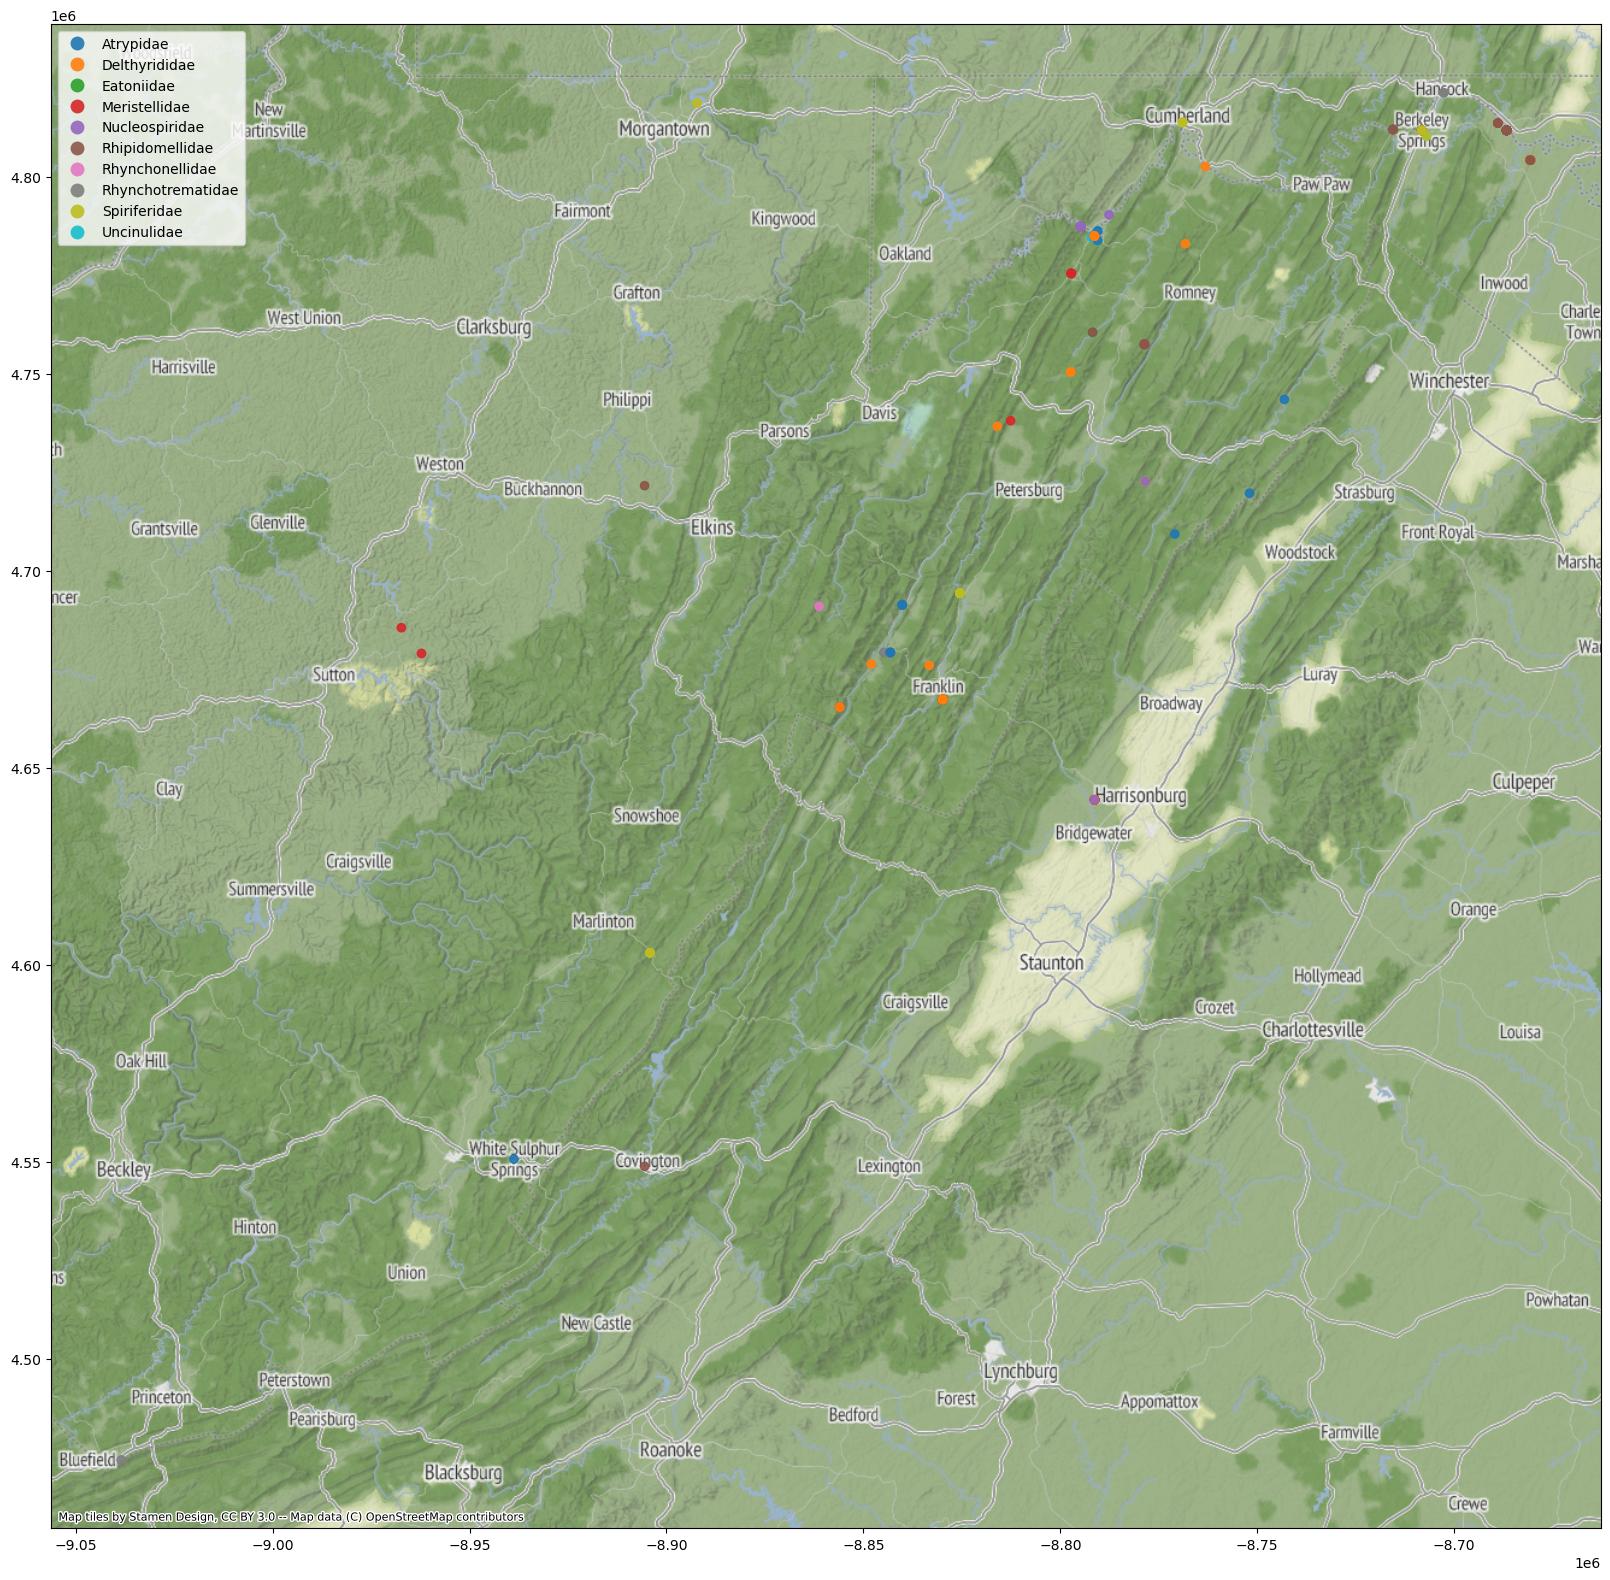

In [36]:
fig, ax = plt.subplots(figsize = (20,20))

master.set_crs(epsg=4326, inplace = True)
#reproject to web mercator
master_wm = master.to_crs(epsg=3857)
ax = master_wm.plot(column = 'species', ax = ax, legend = True, alpha = 0.9)
cx.add_basemap(ax)
plt.show()

In [37]:
fig.savefig('WV_brachiopod_map.png',bbox_inches='tight')